In [5]:
import praw
import os
import pandas as pd
import numpy as np
from wordcloud import WordCloud 
from PIL import Image
import random
import datetime
import time

In [6]:
CLIENT_ID = "Co_p839bA_wjqA"
CLIENT_SECRET = "XItgYS7EFva2lvU2GOr4gVKvULc"
USER_AGENT = f"python:{CLIENT_ID}:0.1 (by /u/Voidskiz)"

In [7]:
api = praw.Reddit(
    client_id = CLIENT_ID,
    client_secret = CLIENT_SECRET,
    user_agent = USER_AGENT
)

In [8]:
sub = input("Subreddit to search: ").strip()
query = input("Search Query: ").strip()

submisions = api.subreddit(sub).search(query)

posts = []

def redditcall():
    for submission in submisions:
        item = {
            "title" : submission.title,
            "score" : submission.score,
            "comments" : submission.num_comments,
            "author" : submission.author,
            "time" : time.ctime(submission.created_utc),
            "id" : submission.id,
            "permalink": submission.permalink,
            #"url": submission.url,
        }
        posts.append(item)
        
redditcall()

Subreddit to search: thenetherlands
Search Query: zwarte piet


In [9]:
# Checking if we actually got some data
df = pd.DataFrame(posts)
sorted_df = df.sort_values("comments")
sorted_df.tail(1)

,author,comments,id,permalink,score,time,title
15,Mortress,422,593l63,/r/thenetherlands/comments/593l63/rtl_stopt_me...,162,Mon Oct 24 11:12:50 2016,"RTL stopt met Zwarte Piet, voortaan alleen pie..."


In [10]:
c_posts = []

# Only getting posts with at least a few comments
for item in posts:
    if item["comments"] >= 5:
        c_posts.append(item)

# Getting threads with at least 5 comments 
posts_amount = len(posts)
c_posts_amount = len(c_posts)
print(f'{c_posts_amount} posts with 5 or more comments.')

95 posts with 5 or more comments.


In [11]:
# Same thing in dataframe.
df_c = pd.DataFrame(c_posts)
df_c.tail(2)

,author,comments,id,permalink,score,time,title
93,bluepingu,18,2nzc53,/r/thenetherlands/comments/2nzc53/sinterklaas_...,13,Mon Dec 1 22:49:57 2014,Sinterklaas gedicht vraag (English)
94,TonyQuark,22,2jlofo,/r/thenetherlands/comments/2jlofo/please_read_...,11,Sat Oct 18 14:12:49 2014,"Please read: Announcing link flair, including ..."


In [258]:
# Counting comments based on Reddit API data
# However, this is including 'MoreComments' - which we are not scraping.
total = df_c["comments"].sum()
print(f'{total} comments totaal')

6592 comments totaal


In [12]:
# Scraping the actual comments from the individual Reddit Threads. 

all_comments = []
index = 0

for item in c_posts:
    page_id = item["id"]
    submission = api.submission(id=page_id)
    for comment in submission.comments:
        if isinstance(comment, praw.models.MoreComments):
            continue
        item = {
        "author" : comment.author,
        "score" : comment.score,
        "body": comment.body
        }
        all_comments.append(item)
    
    #Giving some feedback on scraper progress
    index = index + 1
    print(f'Thread {index} of {c_posts_amount} scraped for comments.')

Thread 1 of 95 scraped for comments
Thread 2 of 95 scraped for comments
Thread 3 of 95 scraped for comments
Thread 4 of 95 scraped for comments
Thread 5 of 95 scraped for comments
Thread 6 of 95 scraped for comments
Thread 7 of 95 scraped for comments
Thread 8 of 95 scraped for comments
Thread 9 of 95 scraped for comments
Thread 10 of 95 scraped for comments
Thread 11 of 95 scraped for comments
Thread 12 of 95 scraped for comments
Thread 13 of 95 scraped for comments
Thread 14 of 95 scraped for comments
Thread 15 of 95 scraped for comments
Thread 16 of 95 scraped for comments
Thread 17 of 95 scraped for comments
Thread 18 of 95 scraped for comments
Thread 19 of 95 scraped for comments
Thread 20 of 95 scraped for comments
Thread 21 of 95 scraped for comments
Thread 22 of 95 scraped for comments
Thread 23 of 95 scraped for comments
Thread 24 of 95 scraped for comments
Thread 25 of 95 scraped for comments
Thread 26 of 95 scraped for comments
Thread 27 of 95 scraped for comments
Thread 28 

In [260]:
all_df = pd.DataFrame(all_comments)

In [262]:
# Showing the last 10 comments, so we know how many comments the scraper actually collected.
all_df.tail(10)

,author,body,score
1035,Heep_Purple,To add to that: there's a big blue button unde...,4
1036,theorionman,"Okay, I'll start the mandatory complaining (I'...",9
1037,Araikaze,"The new flairs look very useful, but I think t...",4
1038,Astilaroth,ARGH VERANDERINGEN ARGH ARGH.\n\npersoonlijk v...,2
1039,Shizly,"Zo, de flaires zijn echt snel aangepast. Netje...",3
1040,SonOfOrange,"just a heads up, the 'how-to' link is not acce...",2
1041,vlepun,"Nou ja zeg, niet eens de OP in twee talen! WAT...",2
1042,Shizly,"Ik vind de flairs handig, maar wel veel en dan...",1
1043,NotTheInkfish,"Wat grijs allemaal, kunnen er niet leukere kle...",1
1044,None,[deleted],1


In [263]:
# Cleaing up the data with some regexing (getting rid of meaningless junk symbols etc.)
all_df["body"] = all_df['body'].str.replace("[^ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ]", "")

# Also sorting by most common words, putting it into workable dataframe
topwords = pd.Series(" ".join(all_df["body"]).lower().split()).value_counts()[:300]
topwords = pd.DataFrame(topwords)
topwords['actual_word'] = topwords.index
topwords = topwords.rename(columns={ topwords.columns[0]: "amount" })

In [266]:
# showing the most common words
topwords.head(10)

,amount,actual_word
de,1520,de
het,1220,het
een,1025,een
dat,934,dat
is,870,is
van,830,van
en,812,en
ik,753,ik
niet,630,niet
in,592,in


In [342]:
# So yeah, this is a problem. 
# We gotta delete some standard/stopwords and small words to get a more meaningful picture of words being used. 

morethanfour = []
forbidden_words = ["mensen","vind","gewoon","weer","zelf","iedereen","willen","laten","juist","that","word","staan","waren","artikel","werd","bent","geweest","zitten","weten","genoeg","ander","lang","persoon","best","gebruiken","hadden","bijvoorbeeld","tussen","hand","zitten","bent","geweest","waarom","zeggen","zoals","paar","misschien","zien","zich","altijd","naar","gezien","mijn","want","beetje","echt","niet","maar","zijn","voor","achter","over","onder","hebben", "door","meer","heeft","hier","geven","niets","niks","laat","eigenlijk","zullen","iemand","steeds","deleted","lijkt","komen","komt","geen","worden","wordt","helemaal","kunnen","alsof","even","deze","heel","alleen","hele","veel","waar","moeten","omdat","toch","worden","wordt","gaan","moet","andere","eens","doen","daar","iets","gaat","maken","nooit","allemaal","alle","manier","anders","grote","weet","dingen","denken","vraag","alles","this","enige","maakt","krijgen","doet","ziet","zegt","zouden","zonder","keer","alsof"]
#stopwords = pd.read_csv('stopwords.csv')

index = 0

for word in topwords["actual_word"]:
    freq = topwords["amount"][index]
    index = index + 1
    if len(word) >= 4 and word not in forbidden_words: # and word not in stopwords:
        item = {
            "word": word,
            "frequency": freq
        }
        morethanfour.append(item)

In [360]:
# Checking if we got some meaningful results now.
mcw_cleaned = pd.DataFrame(morethanfour)
mcw_cleaned.head(10)

,frequency,word
0,486,zwarte
1,429,piet
2,117,discussie
3,102,kinderen
4,89,tegen
5,86,pieten
6,85,sinterklaas
7,82,nederland
8,71,jaar
9,69,goed


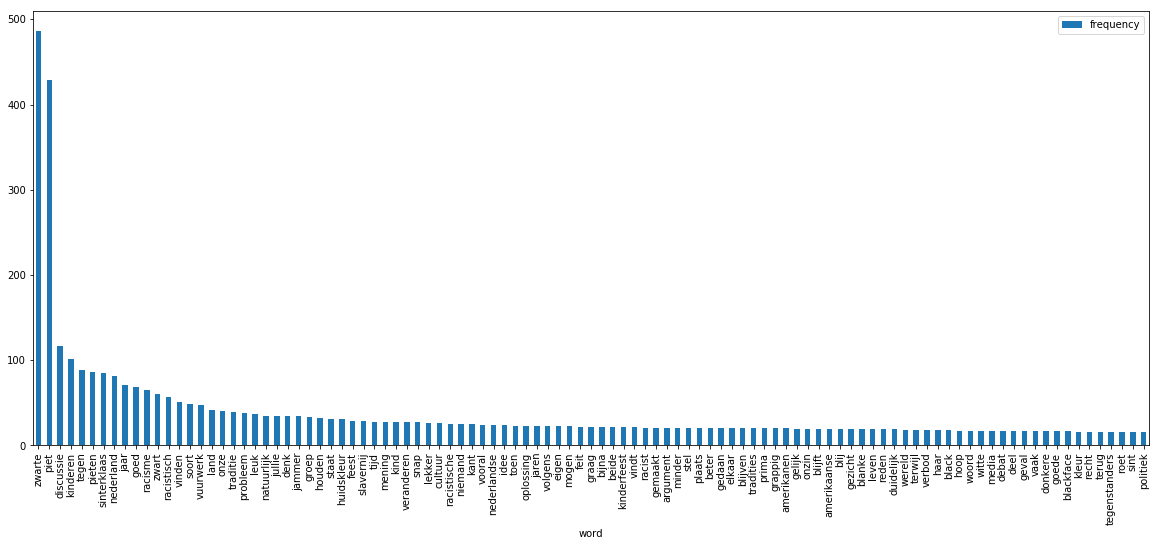

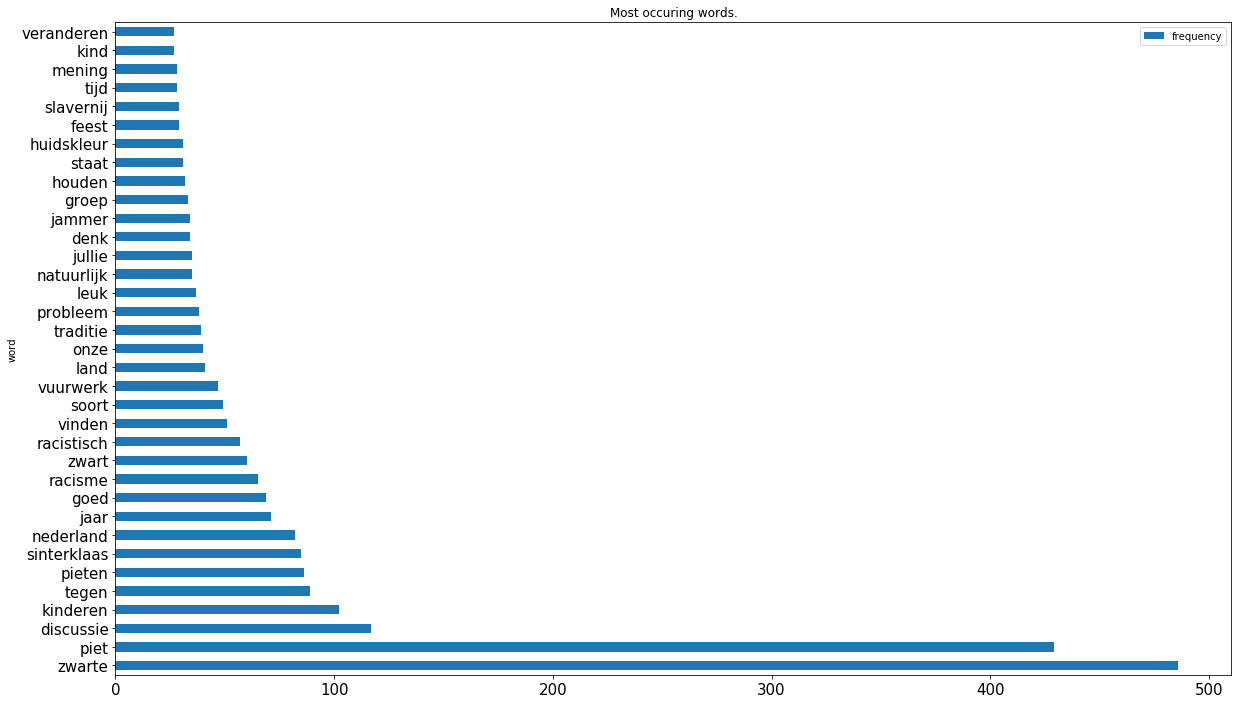

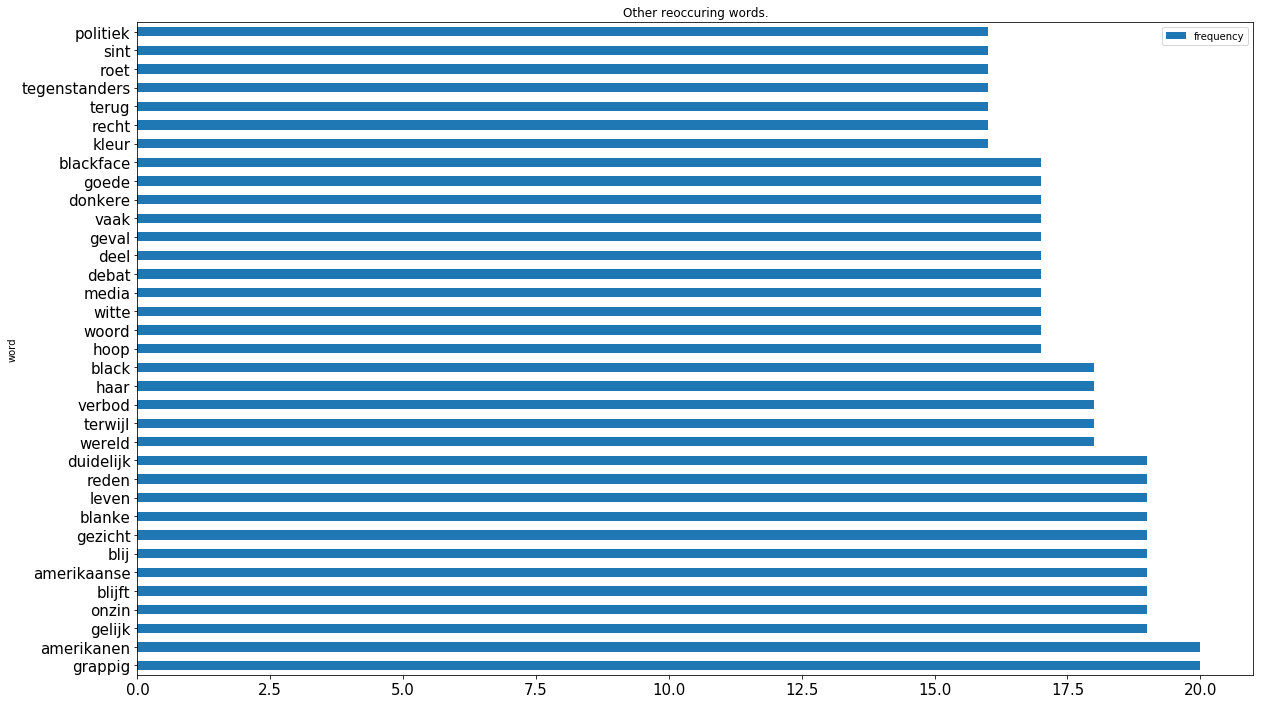

In [373]:
# Visualizing our results. 
words_bargraph = mcw_cleaned.plot(kind="bar",x="word",figsize=(20,8))
head_bargraph = mcw_cleaned.head(35)
head_bargraph.plot(kind="barh",x="word",figsize=(20,12), title="Most occuring words.", fontsize="15")
tail_bargraph = mcw_cleaned.tail(35)
tail_bargraph.plot(kind="barh",x="word",figsize=(20,12), title="Other reoccuring words.", fontsize="15")

In [350]:
# Converting the text into one big string, so we can use it as a WordCloud. 
wordcloud_text_list = []

for item in morethanfour:
    freq = item["frequency"]
    word = item["word"] 
    wordspam = freq * (word + ".")
    wordspam = wordspam.split(".")
    if item is not '':
        wordcloud_text_list.extend(wordspam)

# Randomizing order of words, else WordCloud library acts in a weird way...
random.shuffle(wordcloud_text_list)        
wordcloud_text = ' '.join(wordcloud_text_list)

# Creating wordcloud
mask = np.array(Image.open("wordcloudBG.png"))
wc = WordCloud(background_color="white",mask=mask,max_words=250)
wc.generate(wordcloud_text)
wc.to_file("reddit_wordcloud.png")

In [ ]:
# eventueel nog twitter/fb... minder anoniem...